In [61]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse


#from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
#import warnings
#warnings.filterwarnings('ignore')


/home/mikejones/anaconda3/bin/python


In [3]:
## load hde
hde_filename = 'hde_pkls/trim_400_lag_32_sm_6_ep_30-comb_cut4_training_GC-mid_230-10000-190.pkl'

with open(hde_filename, 'rb') as pickle_file:
    hde = pickle.load(pickle_file)

print(hde)






HDE(activation=None, batch_normalization=True, batch_size=50000,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7fc501fa01d0>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=190,
    l2_regularization=0.0, lag_time=32, latent_space_noise=0,
    learning_rate=0.01, n_components=6, n_epochs=30, reversible=True,
    validation_split=0.2, verbose=True)


In [4]:
## load equilibrium data to transform

#load distances
npy_equ = 'mdtraj-pwdr-allseq_15ts_15e+09run_GC-mid_324K-10-150001-190.npy'
npy_lowT = 'comb_cut4_training_GC-mid_230-10000-190.npy'
n_traj = 150

## load equilibirum and low T data
load_path = '/home/mikejones/scratch-midway2/srv/dna_data/'
equ_data = np.load(load_path + npy_equ)
lowT_data = np.load(load_path + npy_lowT)[:n_traj]

# scale equilibrium data
equ_data_c = np.concatenate(equ_data)
scaler = pre.MinMaxScaler(feature_range=(0, 1))
scaler.fit(equ_data_c)
equ_data_s = [scaler.transform(item) for item in equ_data] 

# scale lowT data
lowT_data_c = np.concatenate(lowT_data)
scaler = pre.MinMaxScaler(feature_range=(0, 1))
scaler.fit(lowT_data_c)
lowT_data_s = [scaler.transform(item) for item in lowT_data] 


equ_hde = [hde.transform(x) for x in equ_data_s]
lowT_hde = [hde.transform(x) for x in lowT_data_s]

equ_hde_c = np.concatenate(equ_hde)
lowT_hde_c = np.concatenate(lowT_hde)

In [5]:
print(np.shape(equ_hde))
print(np.shape(lowT_hde))

(10, 150001, 6)
(150, 10000, 6)


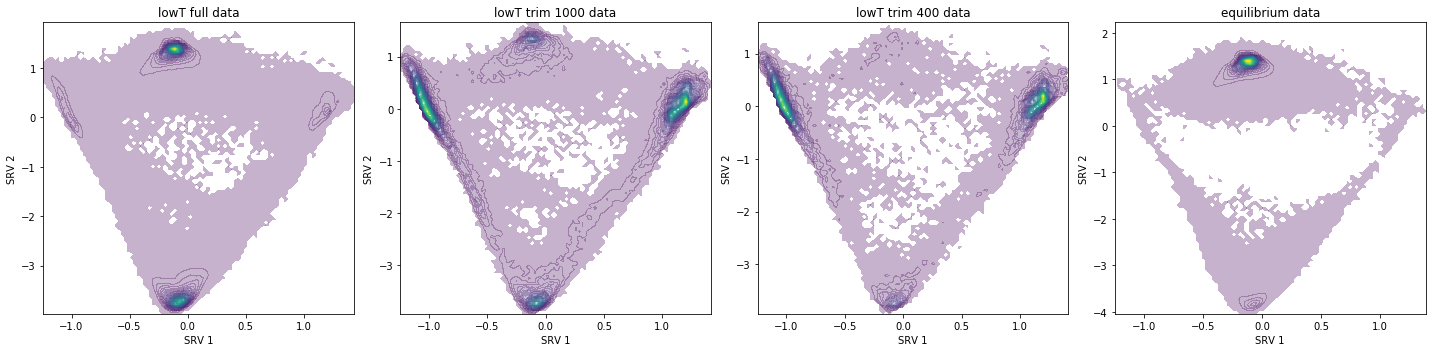

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
pyemma.plots.plot_density(
    *lowT_hde_c[:, :2].T, ax=ax[0], cbar=False, alpha=0.3)
ax[0].set_xlabel('SRV 1')
ax[0].set_ylabel('SRV 2')
ax[0].set_title('lowT full data')

pyemma.plots.plot_density(
    *np.concatenate([item[4500:5500] for item in lowT_hde])[:, :2].T, ax=ax[1], cbar=False, alpha=0.3)
ax[1].set_xlabel('SRV 1')
ax[1].set_ylabel('SRV 2')
ax[1].set_title('lowT trim 1000 data')

pyemma.plots.plot_density(
    *np.concatenate([item[4800:5200] for item in lowT_hde])[:, :2].T, ax=ax[2], cbar=False, alpha=0.3)
ax[2].set_xlabel('SRV 1')
ax[2].set_ylabel('SRV 2')
ax[2].set_title('lowT trim 400 data')

pyemma.plots.plot_density(
    *equ_hde_c[:, :2].T, ax=ax[3], cbar=False, alpha=0.3)
ax[3].set_xlabel('SRV 1')
ax[3].set_ylabel('SRV 2')
ax[3].set_title('equilibrium data')

fig.tight_layout()

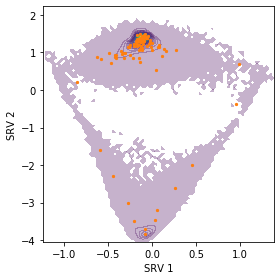

In [34]:
## cluster discrete microstates

cluster = pyemma.coordinates.cluster_kmeans(
    equ_hde, k=100, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *equ_hde_c[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('SRV 1')
ax.set_ylabel('SRV 2')
fig.tight_layout()



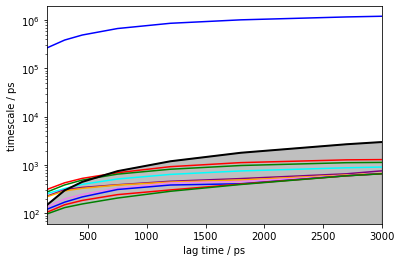

In [35]:
#plotting timescales
its = pyemma.msm.its(cluster.dtrajs, lags=20, nits=10)
pyemma.plots.plot_implied_timescales(its, units='ps', dt=150);

In [53]:
## build msm
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=6, dt_traj='150 ps')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


In [54]:
## CK test to validate ms
## taking long time to run

'''
nstates = 4
cktest = msm.cktest(nstates, mlags=7)
pyemma.plots.plot_cktest(cktest, dt=1, units='3 ps');
'''

"\nnstates = 4\ncktest = msm.cktest(nstates, mlags=7)\npyemma.plots.plot_cktest(cktest, dt=1, units='3 ps');\n"

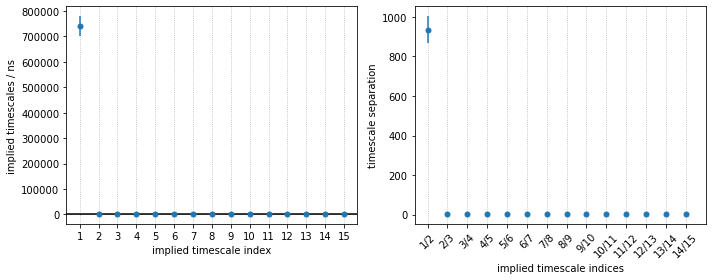

In [55]:
## spectral gap analysis (looking for best way to coarse grain states)

def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

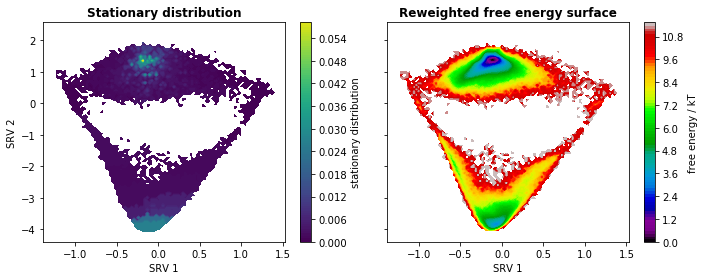

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *equ_hde_c[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *equ_hde_c[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('SRV 1')
axes[0].set_ylabel('SRV 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

The first eigenvector is one: True (min=0.9999999999998465, max=1.0000000000018332)


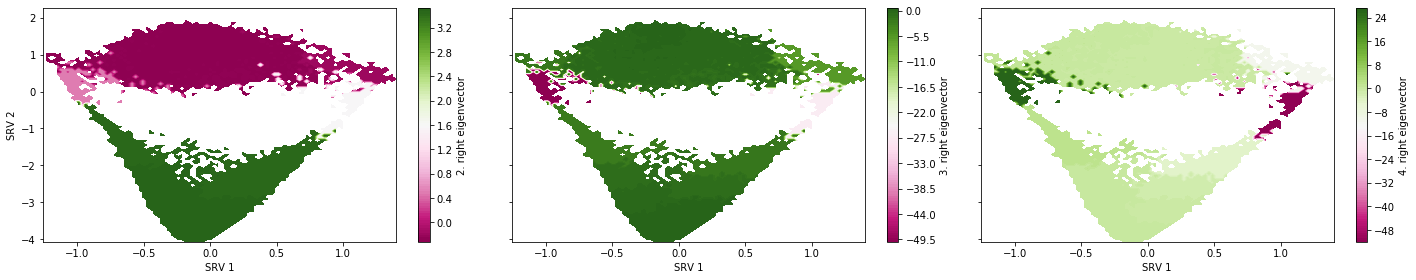

In [57]:
## plotting leading eigenvectors on first two TICA coordinates
n_states = 4
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, n_states - 1, figsize=(5*n_states, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *equ_hde_c[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('SRV 1')
axes[0].set_ylabel('SRV 2')
fig.tight_layout()

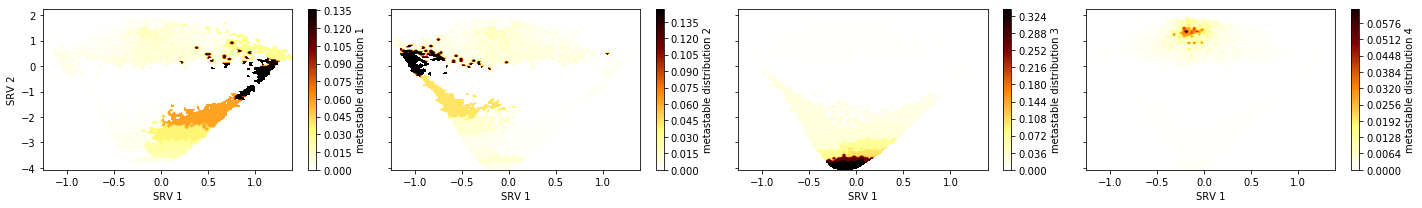

In [58]:
## pca softclustering

fig, axes = plt.subplots(1, n_states, figsize=(5*n_states, 3), sharex=True, sharey=True)
msm.pcca(n_states)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *equ_hde_c[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('SRV 1')
axes[0].set_ylabel('SRV 2')
fig.tight_layout()

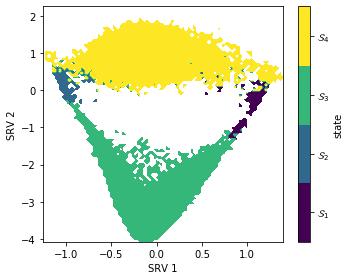

In [59]:
## plot discrete metastable states

metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *equ_hde_c[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('SRV 1')
ax.set_ylabel('SRV 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(n_states)])
fig.tight_layout()

In [60]:
## stationary distribution encoding free energy of states

print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.000264	8.238279
2	0.000307	8.089631
3	0.075904	2.578289
4	0.923525	0.079557


In [49]:
## find MFPT between states

from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(np.log(mfpt), decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,-inf,15.58,15.69,13.14
2,16.00,-inf,16.14,12.33
3,15.24,15.40,-inf,13.83
4,16.15,15.76,16.39,-inf


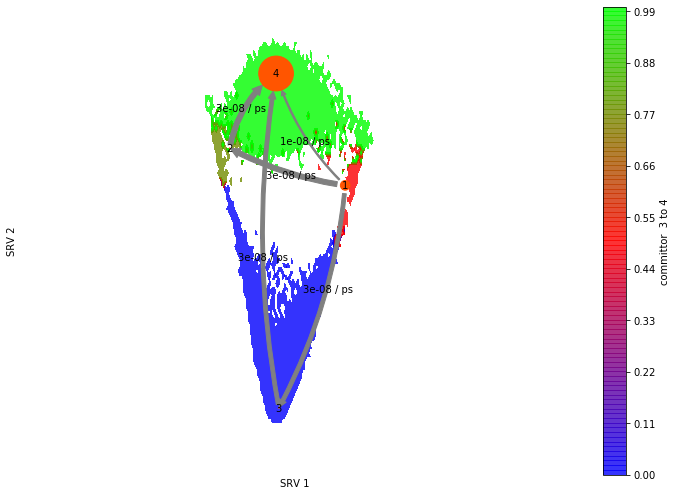

In [52]:
## transition path theory and fluxes

# calculate flux and coarse state centers
start, final = 2, 3
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *equ_hde_c[:, :2].T,
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor  ' + str(start + 1) + ' to ' + str(final + 1),
    alpha=0.8,
    zorder=-1)

pyemma.plots.plot_flux(
    cgflux,
    coarse_state_centers,
    cgflux.stationary_distribution,
    ax=ax,
    show_committor=False,
    figpadding=0.2,
    state_labels=[str(i+1) for i in range(n_states)],
    arrow_label_format='%2.e / ps')

ax.set_xlabel('SRV 1')
ax.set_ylabel('SRV 2')

fig.tight_layout()

(48212, 190)
(190,)
(474, 190)
(190,)
(474, 190)
(190,)


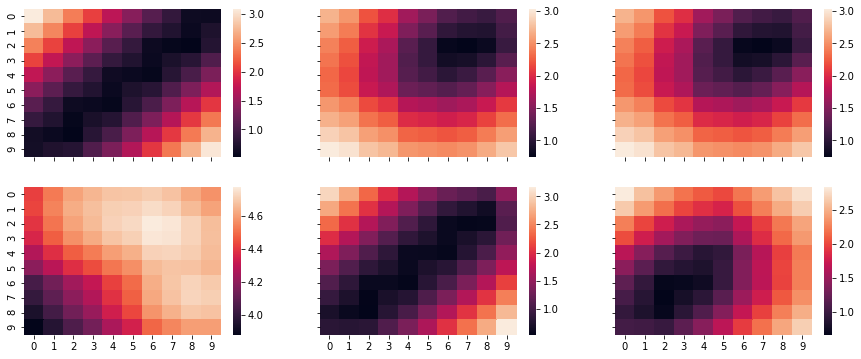

In [51]:
## make heatmaps showing all intermolecular distances across various slow modes
def make_heatmap(frame):

    plot_arr = np.zeros((10, 10))
    for pair in range(100):

        x = int(pair / 10)
        y = pair % 10
        plot_arr[x, y] = frame[pair]
        
    return plot_arr

frames_hde = equ_hde_c
frames_pwd = equ_data_c

frames_list = []

n_sm = nstates - 1
fig, axes = plt.subplots(2, n_sm, figsize=(15, 6), sharex=True, sharey=True)
for i in range(n_sm):
    
    eig_list = eigvec[dtrajs_concatenated, i + 1]
    eig_min = np.where(eig_list == np.amin(eig_list))
    eig_max = np.where(eig_list == np.amax(eig_list))
    
    min_avg = [np.mean(1/equ_data_c[eig_min][:, i]) for i in range(100)]
    max_avg = [np.mean(1/equ_data_c[eig_max][:, i]) for i in range(100)]
                         
    print(np.shape(equ_data_c[eig_min]))
    print(np.shape(equ_data_c[eig_min][i]))
    
    sns.heatmap(make_heatmap(min_avg), ax=axes[0, i])
    sns.heatmap(make_heatmap(max_avg), ax=axes[1, i])
